In [1]:
!python --version
!nvcc --version
!pip list

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Package                          Version
-------------------------------- ------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
auto

termcolor                        2.3.0
terminado                        0.17.1
text-unidecode                   1.3
textblob                         0.17.1
tf-slim                          1.1.0
thinc                            8.1.10
threadpoolctl                    3.2.0
tifffile                         2023.7.18
tinycss2                         1.2.1
toml                             0.10.2
tomli                            2.0.1
toolz                            0.12.0
torch                            2.0.1
torchvision                      0.15.2
tornado                          6.3.1
tqdm                             4.65.0
traitlets                        5.7.1
tweepy                           4.13.0
typeguard                        2.13.3
typer                            0.9.0
types-setuptools                 68.0.0.3
typing_extensions                4.7.1
tzdata                           2023.3
tzlocal                          5.0.1
uc-micro-py                      1.0.2
uritemplat

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

C:\Users\EaglesonLabs\Anaconda2\envs\vit-object-detection\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import pathlib, os, random
data_dir = pathlib.Path("obj/").with_suffix('')
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

def list_files(full_data_path = "obj/", image_ext = '.jpg'):

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")
    random.shuffle(files)
    return files

files = list_files()


1510
218 file(s) discarded
1292 valid case(s)
832 are masked cases


In [5]:
def read_yolo_annotation_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:
        parts = line.strip().split(' ')
        object_class = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        annotations.append((object_class, x_center, y_center, width, height))

    return annotations

In [6]:
image_size = 224  # resize input images to this size
num_classes = 2 # the number of classes in the dataset
images, targets, classes = [], [], []

# loop over the annotations and images, preprocess them and store in lists
for file in files:
    # load the x,y,w,h of the bounding box here as top_left_x/y & bottom_right_x/y
    annotations = read_yolo_annotation_file('obj/' + file + '.txt')
    class_prediction = annotations[0][0]
    top_left_x = annotations[0][1]
    top_left_y = annotations[0][2]
    bottom_right_x = annotations[0][3]
    bottom_right_y = annotations[0][4]
    
    # load the actual image here
    image = keras.utils.load_img("obj/" + file + '.jpg',)
    image = image.resize((image_size, image_size))
    
    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))
    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x),
            float(top_left_y),
            float(bottom_right_x),
            float(bottom_right_y),
        )
    )
    classes.append(to_categorical(class_prediction, num_classes))



# Convert the list to numpy array, split to train and test dataset
(x_train), (bounding_boxes_y_train), (class_labels_y_train) = (
    np.asarray(images[:int( 0.8  *len(images))],dtype=object),
    np.asarray(targets[:int(0.8 * len(targets))],dtype=object),
    np.asarray(classes[:int(0.8 * len(classes))],dtype=object),
)

(x_test), (bounding_boxes_y_test), (class_labels_y_test) = (
    np.asarray(images[int(0.8 * len(images)):],dtype=object),
    np.asarray(targets[int(0.8 * len(targets)):],dtype=object),
    np.asarray(classes[int(0.8 * len(classes)):],dtype=object),
)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
bounding_boxes_y_train = tf.convert_to_tensor(bounding_boxes_y_train, dtype=tf.float32)
class_labels_y_train = tf.convert_to_tensor(class_labels_y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
bounding_boxes_y_test = tf.convert_to_tensor(bounding_boxes_y_test, dtype=tf.float32)
class_labels_y_test = tf.convert_to_tensor(class_labels_y_test, dtype=tf.float32)

bounding_box:  [0.5625     0.61565423 0.63125    0.55841124]
label:  0


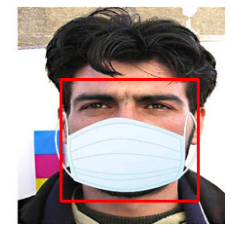

In [7]:
num = 0

image = x_train[num].numpy().astype("uint8")



bounding_box = bounding_boxes_y_train[num].numpy()
label = np.argmax(class_labels_y_train[num].numpy())
print('bounding_box: ', bounding_box)
print('label: ', label)

x_center, y_center = bounding_box[0] * image_size,  bounding_box[1] * image_size
width, height = bounding_box[2] * image_size,  bounding_box[3] * image_size

# Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
x_min = int(x_center - (width / 2))
y_min = int( y_center - (height / 2))
x_max = x_min + int(width)
y_max = y_min + int(height)

top_left = (x_min, y_min)
bottom_right = (x_max, y_max)

# Convert image to RGB if it's grayscale
image = np.squeeze(image)  # Remove the extra batch dimension
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Draw rectangles
cv2.rectangle(image, top_left, bottom_right, (255,0,0), 2)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

In [8]:
architecture_id = 'increased path size'

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

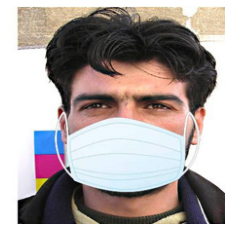

Image size: 224 X 224
Patch size: 20 X 20
121 patches per image 
1200 elements per patch


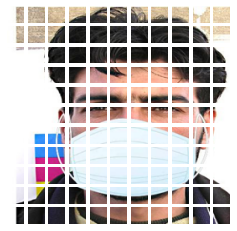

In [11]:
import matplotlib.pyplot as plt

patch_size = 20  # Size of the patches to be extracted from the input images

# Convert the EagerTensor to a NumPy array
x_train_numpy = x_train[0].numpy().astype("uint8")

plt.figure(figsize=(4, 4))
plt.imshow(x_train_numpy)
plt.axis("off")
plt.show()

patches = Patches(patch_size)(tf.convert_to_tensor([x_train_numpy]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Final MLP head for bounding box prediction
    bounding_box = layers.Dense(4, name='bounding_box')(features)

    # Final dense layer for class prediction
    class_predictions = layers.Dense(num_classes, activation='softmax', name='class_predictions')(features)

    # Keras model with both bounding box and class predictions
    model = keras.Model(inputs=inputs, outputs=[bounding_box, class_predictions])

    # return model.
    return model

In [14]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / union

In [15]:
folder_count = 0  # type: int
input_path = "vit-model performance"  # type: str
for folders in os.listdir(input_path):  # loop over all files
    if os.path.isdir(os.path.join(input_path, folders)):  # if it's a directory
        folder_count += 1  # increment counter
new_folder = os.path.join(input_path, 'model '+ str(folder_count) + ' - ' + architecture_id)
os.mkdir(new_folder)

Epoch 1/100
30/30 [==============================] - 10s 129ms/step - loss: 1.1044 - bounding_box_loss: 0.3834 - class_predictions_loss: 0.7211 - bounding_box_calculate_iou: 0.2584 - class_predictions_accuracy: 0.5414 - val_loss: 0.7410 - val_bounding_box_loss: 0.0626 - val_class_predictions_loss: 0.6784 - val_bounding_box_calculate_iou: 0.5673 - val_class_predictions_accuracy: 0.5865
Epoch 2/100
30/30 [==============================] - 3s 112ms/step - loss: 0.7884 - bounding_box_loss: 0.1187 - class_predictions_loss: 0.6697 - bounding_box_calculate_iou: 0.5146 - class_predictions_accuracy: 0.6168 - val_loss: 0.7087 - val_bounding_box_loss: 0.0269 - val_class_predictions_loss: 0.6818 - val_bounding_box_calculate_iou: 0.7437 - val_class_predictions_accuracy: 0.5865
Epoch 3/100
30/30 [==============================] - 3s 113ms/step - loss: 0.7595 - bounding_box_loss: 0.0903 - class_predictions_loss: 0.6693 - bounding_box_calculate_iou: 0.5751 - class_predictions_accuracy: 0.6297 - val_lo

30/30 [==============================] - 3s 114ms/step - loss: 0.3479 - bounding_box_loss: 0.0480 - class_predictions_loss: 0.2999 - bounding_box_calculate_iou: 0.7246 - class_predictions_accuracy: 0.9085 - val_loss: 0.2377 - val_bounding_box_loss: 0.0143 - val_class_predictions_loss: 0.2235 - val_bounding_box_calculate_iou: 0.8538 - val_class_predictions_accuracy: 0.9231
Epoch 23/100
30/30 [==============================] - 3s 116ms/step - loss: 0.3135 - bounding_box_loss: 0.0515 - class_predictions_loss: 0.2620 - bounding_box_calculate_iou: 0.7120 - class_predictions_accuracy: 0.9107 - val_loss: 0.2264 - val_bounding_box_loss: 0.0140 - val_class_predictions_loss: 0.2124 - val_bounding_box_calculate_iou: 0.8521 - val_class_predictions_accuracy: 0.9327
Epoch 24/100
30/30 [==============================] - 4s 117ms/step - loss: 0.2683 - bounding_box_loss: 0.0469 - class_predictions_loss: 0.2214 - bounding_box_calculate_iou: 0.7267 - class_predictions_accuracy: 0.9290 - val_loss: 0.2220 

30/30 [==============================] - 4s 124ms/step - loss: 0.2654 - bounding_box_loss: 0.0202 - class_predictions_loss: 0.2452 - bounding_box_calculate_iou: 0.8066 - class_predictions_accuracy: 0.9096 - val_loss: 0.3362 - val_bounding_box_loss: 0.0131 - val_class_predictions_loss: 0.3231 - val_bounding_box_calculate_iou: 0.8555 - val_class_predictions_accuracy: 0.8750
Epoch 44/100
30/30 [==============================] - 4s 121ms/step - loss: 0.2296 - bounding_box_loss: 0.0200 - class_predictions_loss: 0.2096 - bounding_box_calculate_iou: 0.8149 - class_predictions_accuracy: 0.9247 - val_loss: 0.2557 - val_bounding_box_loss: 0.0141 - val_class_predictions_loss: 0.2416 - val_bounding_box_calculate_iou: 0.8562 - val_class_predictions_accuracy: 0.9231
Epoch 45/100
30/30 [==============================] - 3s 116ms/step - loss: 0.2248 - bounding_box_loss: 0.0214 - class_predictions_loss: 0.2034 - bounding_box_calculate_iou: 0.8089 - class_predictions_accuracy: 0.9160 - val_loss: 0.4172 

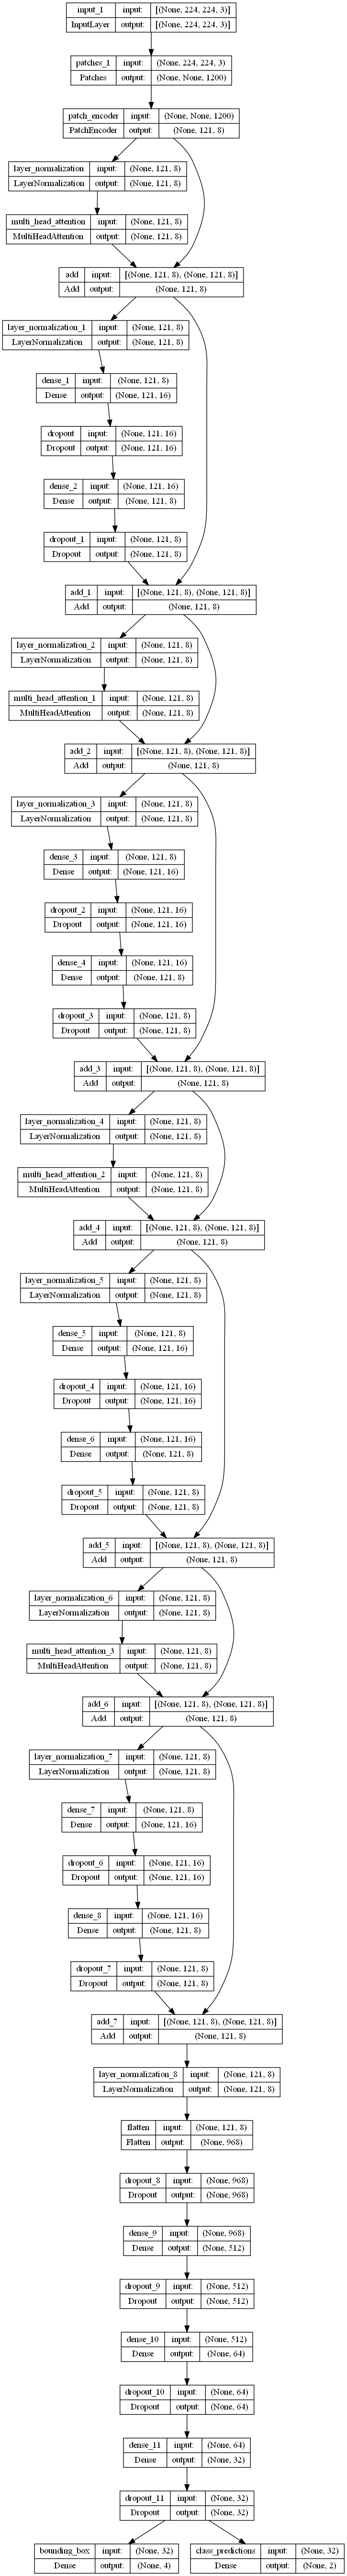

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # Compile the model with appropriate loss functions
    model.compile(
        optimizer='adam',
        loss={'bounding_box': 'mse', 'class_predictions': 'binary_crossentropy'},
        metrics = {'class_predictions' : 'accuracy', 'bounding_box' : calculate_iou }
    )
    
    # Train the model using both bounding_boxes_y and class_labels_y as y-values.
    history = model.fit(
        x = x_train,    # Your training image data
        y = {'bounding_box': bounding_boxes_y_train, 'class_predictions': class_labels_y_train},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=30),
        ],
    )
    
    dot_img_file = os.path.join(new_folder, 'architecture.png')
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(dot_img_file))
    return history, model



input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
projection_dim = 8
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history, model = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

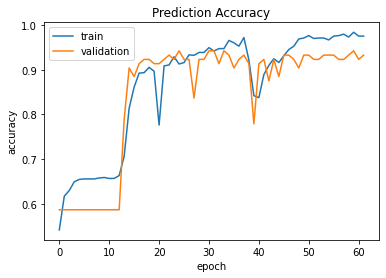

In [17]:
plt.plot(history.history['class_predictions_accuracy'])
plt.plot(history.history['val_class_predictions_accuracy'])
plt.title('Prediction Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'class predictions accuracy.png')
plt.savefig(model_file)
plt.show()

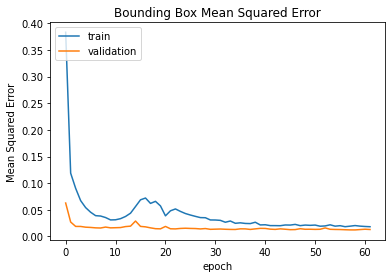

In [18]:
plt.plot(history.history['bounding_box_loss'])
plt.plot(history.history['val_bounding_box_loss'])
plt.title('Bounding Box Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'bounding box mean squared error.png')
plt.savefig(model_file)
plt.show()

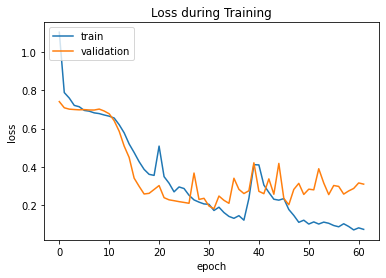

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss during Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'loss.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()

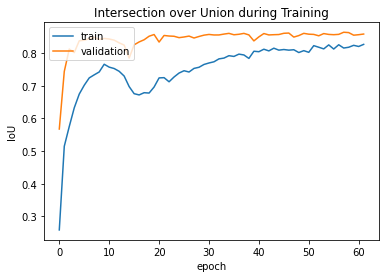

In [20]:
plt.plot(history.history['bounding_box_calculate_iou'])
plt.plot(history.history['val_bounding_box_calculate_iou'])
plt.title('Intersection over Union during Training')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'IoU.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()


predicted_box_coords:  [0.5143944  0.5141355  0.42165878 0.52529424]
actual_box_coords [0.5249433  0.33506495 0.3605442  0.45194805]
predicted_label:  0
actual_label:  1


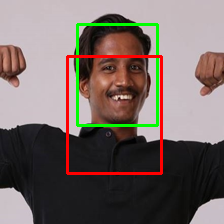

predicted_box_coords:  [0.49573544 0.4676838  0.45965427 0.51066566]
actual_box_coords [0.55583334 0.5208333  0.315      0.435     ]
predicted_label:  1
actual_label:  0


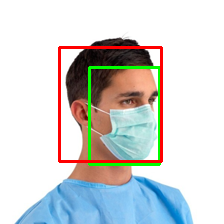

predicted_box_coords:  [0.52741283 0.52595204 0.42682987 0.53859526]
actual_box_coords [0.36531988 0.275      0.34680134 0.275     ]
predicted_label:  0
actual_label:  1


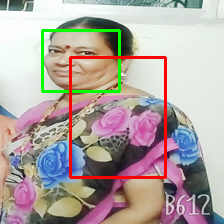

predicted_box_coords:  [0.50326383 0.46161258 0.48233178 0.50642294]
actual_box_coords [0.54625    0.59761906 0.305      0.75238097]
predicted_label:  1
actual_label:  0


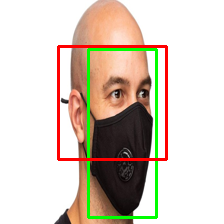

predicted_box_coords:  [0.5147611  0.55023694 0.59047997 0.6112851 ]
actual_box_coords [0.24868421 0.4878049  0.16578947 0.25891182]
predicted_label:  1
actual_label:  0


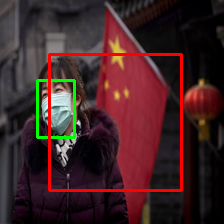

predicted_box_coords:  [0.50023204 0.5308732  0.58861446 0.5702256 ]
actual_box_coords [0.49007937 0.6866197  0.5595238  0.5140845 ]
predicted_label:  1
actual_label:  0


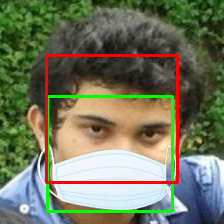

predicted_box_coords:  [0.5048906  0.50675297 0.41856712 0.5231535 ]
actual_box_coords [0.5123967  0.52163464 0.40495867 0.64903843]
predicted_label:  0
actual_label:  1


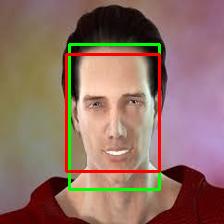

predicted_box_coords:  [0.50206196 0.55592394 0.5899719  0.61318517]
actual_box_coords [0.316 0.561 0.36  0.56 ]
predicted_label:  1
actual_label:  0


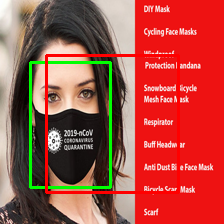

predicted_box_coords:  [0.50373065 0.50791276 0.5474564  0.55551195]
actual_box_coords [0.540625 0.485    0.43375  0.5575  ]
predicted_label:  1
actual_label:  0


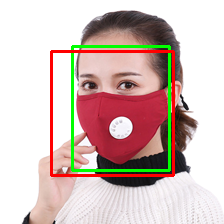

predicted_box_coords:  [0.5028023  0.5460518  0.61718047 0.61499953]
actual_box_coords [0.4989011  0.439      0.44981685 0.558     ]
predicted_label:  1
actual_label:  0


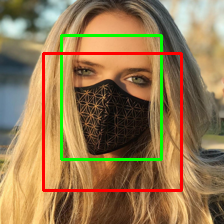

predicted_box_coords:  [0.5292733  0.52302283 0.42995602 0.53439116]
actual_box_coords [0.50333333 0.3215859  0.34       0.27753305]
predicted_label:  0
actual_label:  1


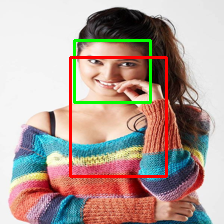

predicted_box_coords:  [0.52166164 0.5187642  0.42145967 0.53687763]
actual_box_coords [0.40727273 0.49726775 0.23272727 0.44808742]
predicted_label:  0
actual_label:  1


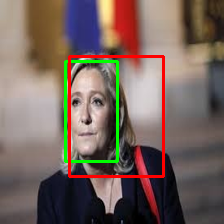

predicted_box_coords:  [0.51591754 0.5561135  0.63336974 0.63909405]
actual_box_coords [0.5769231  0.23326673 0.17076923 0.23076923]
predicted_label:  1
actual_label:  0


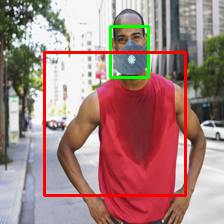

predicted_box_coords:  [0.51092935 0.5196871  0.5609644  0.60074794]
actual_box_coords [0.36690646 0.2845304  0.19424461 0.38121548]
predicted_label:  0
actual_label:  1


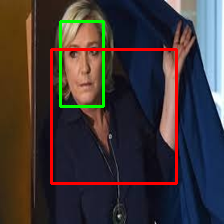

predicted_box_coords:  [0.4820713  0.5254216  0.5371537  0.54756474]
actual_box_coords [0.50666666 0.64285713 0.30666667 0.63095236]
predicted_label:  1
actual_label:  0


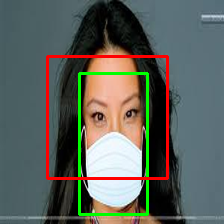

predicted_box_coords:  [0.48779446 0.49463105 0.5057918  0.5258542 ]
actual_box_coords [0.52459013 0.3272727  0.3387978  0.29090908]
predicted_label:  1
actual_label:  0


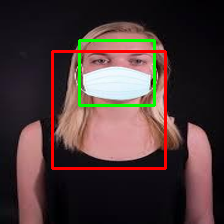

predicted_box_coords:  [0.5254572  0.5064048  0.534463   0.55537677]
actual_box_coords [0.537037   0.36597222 0.35555556 0.38194445]
predicted_label:  0
actual_label:  1


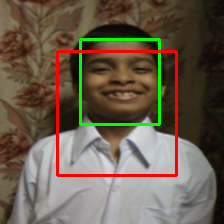

predicted_box_coords:  [0.5275486  0.5052496  0.4155667  0.53086674]
actual_box_coords [0.49726775 0.41272727 0.6666667  0.6727273 ]
predicted_label:  0
actual_label:  1


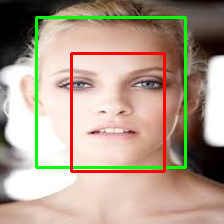

predicted_box_coords:  [0.49217346 0.5171038  0.47190613 0.53541   ]
actual_box_coords [0.4329897 0.3977505 0.371134  0.2965235]
predicted_label:  1
actual_label:  0


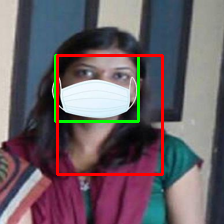

predicted_box_coords:  [0.5270873 0.5468669 0.5680413 0.6007946]
actual_box_coords [0.7074219  0.6201389  0.38359374 0.7236111 ]
predicted_label:  1
actual_label:  0


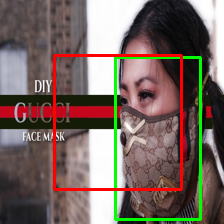

predicted_box_coords:  [0.50326383 0.46161258 0.48233178 0.50642294]
actual_box_coords [0.536875   0.61904764 0.30625    0.7047619 ]
predicted_label:  1
actual_label:  0


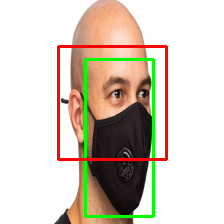

predicted_box_coords:  [0.5044306  0.5232013  0.55108523 0.5721806 ]
actual_box_coords [0.52469134 0.67988396 0.6098765  0.5551257 ]
predicted_label:  1
actual_label:  0


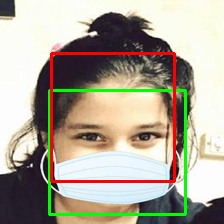

predicted_box_coords:  [0.51768374 0.5002647  0.507309   0.5348482 ]
actual_box_coords [0.5807292  0.38489583 0.35416666 0.43020833]
predicted_label:  0
actual_label:  1


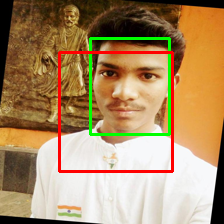

predicted_box_coords:  [0.38318554 0.21157902 0.640457   0.44953686]
actual_box_coords [0.40416667 0.36484376 0.48333332 0.3390625 ]
predicted_label:  1
actual_label:  0


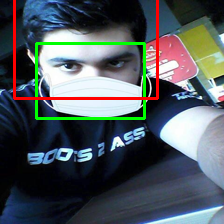

In [21]:
from IPython.display import display
from PIL import Image
for i in range(0, len(x_test)):
    image = x_test[i].numpy().astype("uint8")
    # Add an additional dimension for batch size
    image = np.expand_dims(image, axis=0)
    x_center_actual = bounding_boxes_y_test[i][0] * image_size
    y_center_actual = bounding_boxes_y_test[i][1] * image_size
    width_actual = bounding_boxes_y_test[i][2] * image_size
    height_actual = bounding_boxes_y_test[i][3] * image_size

    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min_actual = int(x_center_actual - (width_actual / 2))
    y_min_actual = int( y_center_actual - (height_actual / 2))
    x_max_actual = x_min_actual + int(width_actual)
    y_max_actual = y_min_actual + int(height_actual)

    top_left_actual = (x_min_actual, y_min_actual)
    bottom_right_actual = (x_max_actual, y_max_actual)




    predictions = model(image)


    # Extract the bounding box center coordinates from predictions
    predicted_box_coords = predictions[0].numpy()[0]
    x_center, y_center = predicted_box_coords[0] * image_size,  predicted_box_coords[1] * image_size
    width, height = predicted_box_coords[2] * image_size,  predicted_box_coords[3] * image_size

    #Extract the prediction label
    predicted_labels = predictions[1].numpy()[0]
    #print('predicted_labels: ', predicted_labels)
    predicted_label =  np.argmax(predicted_labels)
    actual_label =  np.argmax(class_labels_y_test[i].numpy())
    
    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min = int(x_center - (width / 2))
    y_min = int( y_center - (height / 2))
    x_max = x_min + int(width)
    y_max = y_min + int(height)

    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    # Convert image to RGB if it's grayscale
    image = np.squeeze(image)  # Remove the extra batch dimension
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Now use the tuple coordinates in the cv2.rectangle function
    color = (0, 255, 0)  # Set green for actual
    # Draw rectangles
    image = cv2.rectangle(image, top_left_actual, bottom_right_actual, color, 2)
    color = (255, 0, 0)  # Set red for prediction
    # Draw rectangles
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    #only print the cases where the labels disagreed
    if actual_label != predicted_label:
        print('predicted_box_coords: ', predicted_box_coords)
        print('actual_box_coords', bounding_boxes_y_test[i].numpy())
        print('predicted_label: ', predicted_label)
        print('actual_label: ', actual_label)
        # Convert the numpy array to a PIL Image
        image_pil = Image.fromarray(image)
        # Display the image and make it persist
        display(image_pil)